In [361]:
import pandas as pd
import numpy as np
import sys

from sklearn.pipeline import Pipeline
from sklearn.preprocessing import LabelEncoder
from sklearn.linear_model import SGDClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.calibration import CalibratedClassifierCV

import time

from pathlib import Path
import os

import datetime
import pickle 
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
import pandas as pd
import numpy as np
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt
from sklearn.utils import resample



## set up for imports of .py modules by adding path to sys.path

In [362]:
path = Path(os.getcwd())
path = str(path)
print(path)
sys.path.insert(1, path)

/Users/jakeinger/Desktop/school/Supervised Machine Learning /assign_3


In [363]:
import utils.numerical_attr_eda_utils as num_eda_utils
import utils.categorical_attr_eda_utils as cat_eda_utils
import utils.all_attr_eda_utils as all_attr_eda_utils
import utils.attr_eda_utils as attr_eda_utils
import utils.assign_and_lab_utils as al_utils
import utils.multi_class_target_encoder_utils as mc_te_utils
import utils.classification_utils as class_utils
import utils.classifier_hyp_param_grid as cl_hpg

## set up to time script run time

In [364]:
start = time.time()

## parameters

In [365]:
path_to_data = 'synth_2_class_50000_0_87_0_13_15_6_4_1_4_0_0_1_0_w_noms.csv'


train_test_split_random_state = 42
train_validation_split_random_state = 42
fast_script_dev = False  # use True when developing new script features
model_random_state = 42
test_size = 0.20
target_attr = 'y'
prediction_task_type = 'classification'
sgd_max_iter = 10000
binary = True
missingness_threshold = 0.20
calibrate_classifiers = True

## import data

In [366]:
df = pd.read_csv(path_to_data)
print(df.shape)
df.head()

(50000, 17)


,attr_0,attr_1,attr_2,attr_3,attr_4,attr_5,attr_6,attr_7,attr_8,attr_9,attr_10,attr_11,attr_12,attr_13,attr_14,attr_15,y
0,26733,0.073442,-0.169785,cat_1,0.073442,0.198607,cat_7,0.446767,1.635050,-1.464814,cat_12,-0.346873,cat_2,-0.371383,cat_4,0.568886,neg
1,33996,0.258604,0.150201,cat_2,0.258604,0.090455,cat_9,0.214537,1.270424,0.116004,cat_13,0.914826,cat_1,-1.712266,cat_3,1.621075,neg
2,20423,-3.540753,0.711524,cat_2,-3.540753,NaN,cat_13,2.013681,1.599583,NaN,cat_20,-0.178984,cat_1,-1.400692,cat_4,4.045296,neg
3,17716,1.587840,0.064599,cat_2,1.587840,0.061815,cat_9,-0.836880,-1.286857,0.177277,cat_13,3.371167,cat_1,-1.855111,cat_5,0.751476,neg
4,49103,-1.692882,0.586115,cat_2,-1.692882,-0.729148,cat_9,-0.136649,-1.097537,0.323573,cat_15,-1.210027,cat_1,-0.570196,cat_4,0.965486,neg


## drop observations with nans in the target attribute

### this can be out of pipeline because when the trained composite estimator predicts on unseen data there is no target attribute

In [367]:
print(df.shape)
df = df.dropna(subset=target_attr)
print(df.shape)

(50000, 17)
(49503, 17)


## convert target_attr to numerical encoding

### this can be out of pipeline because when the trained composite estimator predicts on unseen data there is no target attribute

In [368]:
if pd.api.types.infer_dtype(df[target_attr]) == 'string':
    df, le_name_mapping = class_utils.label_binarize_binary(df, target_attr, print_results=True)
else:
    print(f'df[target_attr] is not a string attribute')


df[target_attr] is a string attribute

df.loc[0:5, target_attr]:
0    neg
1    neg
2    neg
3    neg
4    neg
Name: y, dtype: object

y
neg    0.870089
pos    0.129911
Name: proportion, dtype: float64

label encode df[target_attr]

after label encoding df[target_attr]

y
0.0    0.870089
1.0    0.129911
Name: proportion, dtype: float64

df.loc[0:5, target_attr]:
0    0.0
1    0.0
2    0.0
3    0.0
4    0.0
Name: y, dtype: float64

lb_name_mapping: {0: 'neg', 1: 'pos'}


## train/test split - delete df afterwards

In [369]:
train_cap_x_df, train_y_df = \
    al_utils.perform_the_train_test_split(
    df, 
    test_size, 
    train_test_split_random_state, 
    val=False,
    stratify=True
)

*************************

df.shape:
(49503, 17)

target class fractional balance:
y
0.0    0.870089
1.0    0.129911
Name: count, dtype: float64

*************************

train_df.csv:
(39602, 16) (39602, 1)

target class fractional balance:
y
0.0    0.870082
1.0    0.129918
Name: count, dtype: float64

*************************

test_df.csv
(9901, 16) (9901, 1)

target class fractional balance:
y
0.0    0.870114
1.0    0.129886
Name: count, dtype: float64


In [370]:
del df

## train/validation split

In [371]:
train_cap_x_df, train_y_df = \
    al_utils.perform_the_train_test_split(
        pd.concat([train_cap_x_df, train_y_df], axis=1), 
        test_size, 
        train_validation_split_random_state, 
        val=True,
        stratify=True
)

*************************

df.shape:
(39602, 17)

target class fractional balance:
y
0.0    0.870082
1.0    0.129918
Name: count, dtype: float64

*************************

train_df.csv:
(31681, 16) (31681, 1)

target class fractional balance:
y
0.0    0.87008
1.0    0.12992
Name: count, dtype: float64

*************************

validation_df.csv
(7921, 16) (7921, 1)

target class fractional balance:
y
0.0    0.870092
1.0    0.129908
Name: count, dtype: float64


## drop attributes with missingness above threshold

In [372]:
missingness_drop_list = []
for attr in train_cap_x_df.columns:
    attr_missingness = train_cap_x_df[attr].isna().sum() / train_cap_x_df.shape[0]
    if attr_missingness >= missingness_threshold:
        missingness_drop_list.append(attr)

missingness_drop_list

['attr_5']

## identify non machine learning attributes

### these are attributes that are not meaningful to machine learning - examples include observation identification attributes, etc.

In [373]:
train_cap_x_df.head()

,attr_0,attr_1,attr_2,attr_3,attr_4,attr_5,attr_6,attr_7,attr_8,attr_9,attr_10,attr_11,attr_12,attr_13,attr_14,attr_15
44559,11570,0.735817,0.522216,cat_1,0.735817,NaN,cat_9,0.219416,-0.336938,-1.315258,cat_14,-0.970114,cat_2,-1.253424,cat_6,0.861184
15617,30625,-1.450113,0.964198,cat_1,-1.450113,-1.673457,cat_8,0.856001,-0.088721,-0.966730,cat_13,-0.201276,cat_1,-1.159783,cat_2,2.214892
46300,19779,-1.271233,0.132465,cat_1,-1.271233,-4.442222,cat_10,2.084803,-1.621460,-1.755230,cat_15,2.393785,cat_1,-3.217514,cat_5,5.227647
46619,7005,-1.041757,-0.233804,cat_2,-1.041757,-0.111090,cat_9,NaN,0.700250,-2.443874,cat_16,-1.537644,cat_2,-1.066501,cat_5,1.259760
45447,47760,-0.006268,0.312587,cat_2,-0.006268,1.752803,cat_12,NaN,1.755318,-0.256351,cat_15,-0.710990,cat_2,-0.226586,cat_4,1.079705


In [374]:
concern_list = all_attr_eda_utils.check_for_complete_unique_attrs(train_cap_x_df)
print(f'\nconcern_list:\n{concern_list}', sep='')

attr_0; 31681; int64; 31681 examine more closely
attr_1; 30760; float64; 31681 
attr_2; 31681; float64; 31681 examine more closely
attr_3; 5; object; 31681 
attr_4; 31681; float64; 31681 examine more closely
attr_5; 21271; float64; 31681 
attr_6; 20; object; 31681 
attr_7; 28432; float64; 31681 
attr_8; 31072; float64; 31681 
attr_9; 30152; float64; 31681 
attr_10; 25; object; 31681 
attr_11; 31681; float64; 31681 examine more closely
attr_12; 4; object; 31681 
attr_13; 28984; float64; 31681 
attr_14; 8; object; 31681 
attr_15; 31681; float64; 31681 examine more closely

concern_list:
['attr_0', 'attr_2', 'attr_4', 'attr_11', 'attr_15']


In [375]:
non_ml_attr_list = ['attr_0']

## identify attributes to drop from machine learning 

### these are attributes that were candidates for machine learning but you have chosen to eliminate from machine learning - elimination can be due to vifs, etc.

In [376]:
train_cap_x_df.columns

Index(['attr_0', 'attr_1', 'attr_2', 'attr_3', 'attr_4', 'attr_5', 'attr_6',
       'attr_7', 'attr_8', 'attr_9', 'attr_10', 'attr_11', 'attr_12',
       'attr_13', 'attr_14', 'attr_15'],
      dtype='object')

In [377]:
ml_attr_drop_list = []

## establish machine learning attribute configuration

#### get all numerical attributes

In [378]:
train_cap_x_df.select_dtypes(include=np.number).columns

Index(['attr_0', 'attr_1', 'attr_2', 'attr_4', 'attr_5', 'attr_7', 'attr_8',
       'attr_9', 'attr_11', 'attr_13', 'attr_15'],
      dtype='object')

#### get all object attributes - these are presumed to be nominal attributes

In [379]:
train_cap_x_df.select_dtypes(include=object).columns

Index(['attr_3', 'attr_6', 'attr_10', 'attr_12', 'attr_14'], dtype='object')

#### assign the attributes

In [380]:
print(f'train_cap_x_df.shape[1]: {train_cap_x_df.shape[1]}')

ml_ignore_list = missingness_drop_list + non_ml_attr_list + ml_attr_drop_list
print('\n', ml_ignore_list)

nominal_attr = ['attr_3', 'attr_6', 'attr_10', 'attr_12', 'attr_14']
print('\n', nominal_attr)

numerical_attr = ['attr_1', 'attr_2', 'attr_4', 'attr_7', 'attr_8', 'attr_9', 'attr_11', 'attr_13', 'attr_15']
print('\n', numerical_attr)

assert(train_cap_x_df.shape[1] == len(ml_ignore_list) + len(nominal_attr) + len(numerical_attr))  # got them all?

print('\n', len(numerical_attr) + len(nominal_attr))
print('\n', numerical_attr + nominal_attr)

train_cap_x_df.shape[1]: 16

 ['attr_5', 'attr_0']

 ['attr_3', 'attr_6', 'attr_10', 'attr_12', 'attr_14']

 ['attr_1', 'attr_2', 'attr_4', 'attr_7', 'attr_8', 'attr_9', 'attr_11', 'attr_13', 'attr_15']

 14

 ['attr_1', 'attr_2', 'attr_4', 'attr_7', 'attr_8', 'attr_9', 'attr_11', 'attr_13', 'attr_15', 'attr_3', 'attr_6', 'attr_10', 'attr_12', 'attr_14']


## assess target attribute unbalanced

In [381]:
train_y_df[target_attr].unique().tolist()

[0.0, 1.0]

In [382]:
train_y_df[target_attr].value_counts(normalize=True)

y
0.0    0.87008
1.0    0.12992
Name: proportion, dtype: float64

## steps to deal with unbalanced classes

## survey/evaluate default composite estimators with ranking metrics

### define the estimators involved in the experiment

####  use default instantiations (except for random_state, class_weight and a few others as noted below)

In [383]:
estimator_names = [
    'SGDClassifier', 
    'DecisionTreeClassifier', 
#     'RandomForestClassifier', 
#     'AdaBoostClassifier', 
#     'GradientBoostingClassifier'
]

estimator_list = [
    
    SGDClassifier(loss='log_loss', random_state=model_random_state, class_weight='balanced',
                  max_iter=sgd_max_iter),  # logistic regr
    
    DecisionTreeClassifier(criterion='log_loss', random_state=model_random_state, class_weight='balanced'),
    
    RandomForestClassifier(criterion='log_loss', random_state=model_random_state, 
                           class_weight='balanced_subsample'),
    
    AdaBoostClassifier(
        estimator=DecisionTreeClassifier(
            criterion='log_loss', 
            random_state=model_random_state, 
            class_weight='balanced',
            max_depth=1
        ),
        random_state=model_random_state
    ),
    
    GradientBoostingClassifier(loss='log_loss', random_state=model_random_state),
    
]

### fit the default default models and evaluate performance on the train set

In [384]:
####################################################################
# class_eval_dict:
#    key = name of function in classification_utils.py
#    value = [bool, function kwargs]  bool = True then call function
print_plots = False
class_eval_dict={
    'binary': binary,
    'scoring': 'average_precision',
    'get_precision_recall_curves': [True, 
                                    {'print_prc': print_plots, 
                                     'print_prd': print_plots,
                                    }],
    'get_roc_curve': [True, 
                      {
                        'print_roc': print_plots,
                      }]
}

default_train_compare_df, trained_default_estimator_dict = \
    al_utils.fit_collection_of_estimators(
        numerical_attr, 
        nominal_attr, 
        estimator_names, 
        estimator_list, 
        train_cap_x_df, 
        train_y_df, 
        data_set_type='train', 
        model_selection_stage='default',
        prediction_task_type='classification',
        class_eval_dict=class_eval_dict
)
default_train_compare_df


**************************************************
default of the SGDClassifier estimator predicting on the train data set

roc_auc_score_: 0.9674402864719259

ave_precision_score: 0.7768870771984117

**************************************************
default of the DecisionTreeClassifier estimator predicting on the train data set

roc_auc_score_: 0.9831383484958337

ave_precision_score: 0.9282427867288235


,ave_precision_score,roc_auc_score_,estimator,data_set_type,model_selection_stage,number_of_attrs,attrs
0,0.776887,0.967440,SGDClassifier,train,default,14,"[attr_1, attr_2, attr_3, attr_4, attr_6, attr_..."
1,0.928243,0.983138,DecisionTreeClassifier,train,default,14,"[attr_1, attr_2, attr_3, attr_4, attr_6, attr_..."


### evaluate the performance of the trained default estimators on the validation set

In [385]:
validation_df = pd.read_csv('validation_df.csv').set_index(keys='index')
validation_df.index.name = None
validation_cap_x_df, validation_y_df = validation_df.iloc[:, :-1], validation_df.iloc[:, -1].to_frame()

In [386]:
# class_eval_dict:
#    key = name of function in classification_utils.py
#    value = [bool, function kwargs]  bool = True then call function
print_plots = False
class_eval_dict={
    'binary': binary,
    'scoring': 'average_precision',
    'get_precision_recall_curves': [True, 
                                    {'print_prc': print_plots, 
                                     'print_prd': print_plots,
                                    }],
    'get_roc_curve': [True, 
                      {
                        'print_roc': print_plots,
                      }]
}


default_validation_compare_df = al_utils.eval_trained_estimators_in_trained_estimator_dict_class(
    trained_default_estimator_dict, 
    validation_cap_x_df, 
    validation_y_df, 
    data_set_type='validation',
    model_selection_stage='default', 
    class_eval_dict=class_eval_dict
)
default_validation_compare_df


**************************************************
default of the SGDClassifier estimator predicting on the validation data set

roc_auc_score_: 0.9659105330217652

ave_precision_score: 0.7646567228775326

**************************************************
default of the DecisionTreeClassifier estimator predicting on the validation data set

roc_auc_score_: 0.8827966764186812

ave_precision_score: 0.6606140831090566


,ave_precision_score,roc_auc_score_,estimator,data_set_type,model_selection_stage,number_of_attrs,attrs
0,0.764657,0.965911,SGDClassifier,validation,default,14,"[attr_1, attr_2, attr_3, attr_4, attr_6, attr_..."
1,0.660614,0.882797,DecisionTreeClassifier,validation,default,14,"[attr_1, attr_2, attr_3, attr_4, attr_6, attr_..."


In [387]:
del validation_cap_x_df, validation_y_df

### assemble a data frame of default estimator performance on the train and validation stage

In [388]:
compare_df = pd.concat([default_train_compare_df, default_validation_compare_df], axis=0).\
    sort_values(['estimator', 'data_set_type', 'model_selection_stage'])
compare_df

,ave_precision_score,roc_auc_score_,estimator,data_set_type,model_selection_stage,number_of_attrs,attrs
1,0.928243,0.983138,DecisionTreeClassifier,train,default,14,"[attr_1, attr_2, attr_3, attr_4, attr_6, attr_..."
1,0.660614,0.882797,DecisionTreeClassifier,validation,default,14,"[attr_1, attr_2, attr_3, attr_4, attr_6, attr_..."
0,0.776887,0.967440,SGDClassifier,train,default,14,"[attr_1, attr_2, attr_3, attr_4, attr_6, attr_..."
0,0.764657,0.965911,SGDClassifier,validation,default,14,"[attr_1, attr_2, attr_3, attr_4, attr_6, attr_..."


### check out vifs of the design matrices for the default models

In [389]:
al_utils.check_out_vifs_of_preprocessed_design_matrices_of_a_collection_of_trained_estimators(
    trained_default_estimator_dict, 
    train_cap_x_df, 
    data_set_type='train',
    model_selection_stage='default_instantiation'
)


********************************************************************************
********************************************************************************
estimator_name: SGDClassifier; data_set_type: train; model_selection_stage: default_instantiation

****************************************
investigate multi co-linearity - calculate variance inflation factors:

Added a bias term to the data frame to construct the design matrix for assessment of vifs.
scale the attributes - but not the bias term

   attribute    vif
0      const   1.00
2     attr_2   1.00
5     attr_6   1.00
6     attr_7   1.00
14   attr_15   1.00
10   attr_11   1.18
11   attr_12   1.28
12   attr_13   1.44
13   attr_14   1.51
7     attr_8   2.05
8     attr_9   4.85
4     attr_4   6.45
9    attr_10  11.35
1     attr_1  32.42
3     attr_3  35.93

********************************************************************************
********************************************************************************
estim

## short list composite estimators based on default estimator findings

To be completed

## hyperparameters tuning on default models using GridSearchCV with ranking metrics

### design the hyperparameter tuning experiment to select the best model by populating the parameter grid with hyperparameter values

In [390]:
alpha_points = 5
l1_ratio_points = 5
m_points = 5

hyp_param_tuning_exp_dict = cl_hpg.get_hyp_param_tuning_exp_dict(
    estimator_names,
    estimator_list, 
    alpha_points, 
    l1_ratio_points, 
    m_points, 
    train_cap_x_df, 
    binary=True,
    fast_script_dev=fast_script_dev, 
    print_param_grids=True
)


************************************************************
************************************************************
SGDClassifier(class_weight='balanced', loss='log_loss', max_iter=10000,
              random_state=42)
{'estimator__penalty': ['l2'], 'estimator__alpha': [0.0001], 'estimator__l1_ratio': [0.15], 'estimator__n_jobs': [None], 'preprocessor__numerical__imputer__strategy': ['mean', 'median'], 'preprocessor__nominal__target_encoder__smooth': ['auto']}

************************************************************
************************************************************
DecisionTreeClassifier(class_weight='balanced', criterion='log_loss',
                       random_state=42)
{'estimator__criterion': ['gini'], 'estimator__splitter': ['best'], 'estimator__max_depth': [None], 'estimator__max_features': [None], 'preprocessor__numerical__imputer__strategy': ['mean', 'median'], 'preprocessor__nominal__target_encoder__smooth': ['auto']}


### perform a grid search over hyper parameters to select best model


********************************************************************************
SGDClassifier
average_precision
Fitting 5 folds for each of 2 candidates, totalling 10 fits

best_index: 0


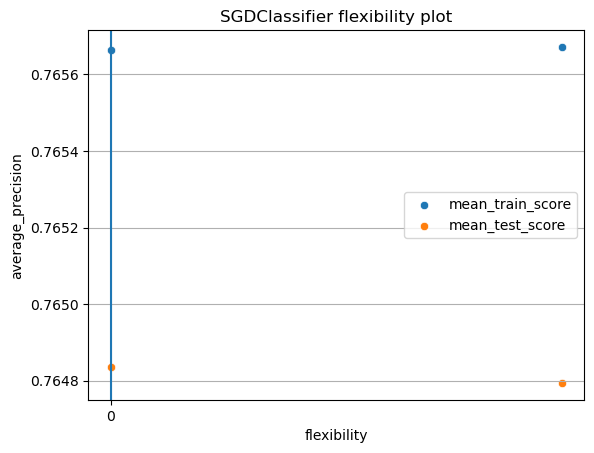


   index  rank_test_score  mean_train_score  mean_test_score
0      0                1          0.765663         0.764835

best_model_hyperparameters:

estimator__alpha: 0.0001
estimator__l1_ratio: 0.15
estimator__n_jobs: None
estimator__penalty: l2
preprocessor__nominal__target_encoder__smooth: auto
preprocessor__numerical__imputer__strategy: median

********************************************************************************
********************************************************************************
estimator_name: SGDClassifier; data_set_type: train; model_selection_stage: tuned_instantiation

****************************************
investigate multi co-linearity - calculate variance inflation factors:

Added a bias term to the data frame to construct the design matrix for assessment of vifs.
scale the attributes - but not the bias term

   attribute    vif
0      const   1.00
2     attr_2   1.00
5     attr_6   1.00
6     attr_7   1.00
14   attr_15   1.00
10   attr_11   1

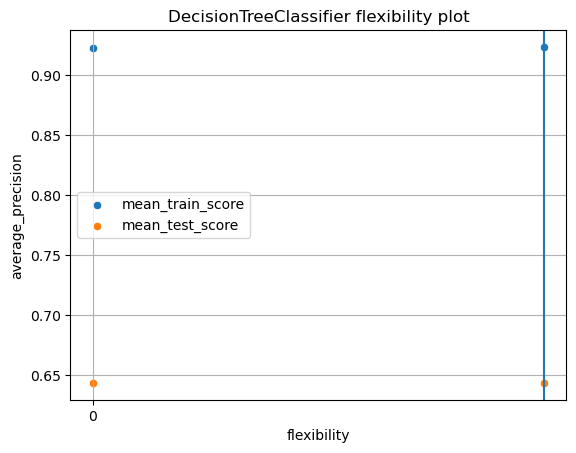


   index  rank_test_score  mean_train_score  mean_test_score
1      1                1          0.923819         0.643992

best_model_hyperparameters:

estimator__criterion: gini
estimator__max_depth: None
estimator__max_features: None
estimator__splitter: best
preprocessor__nominal__target_encoder__smooth: auto
preprocessor__numerical__imputer__strategy: mean

********************************************************************************
********************************************************************************
estimator_name: DecisionTreeClassifier; data_set_type: train; model_selection_stage: tuned_instantiation

****************************************
investigate multi co-linearity - calculate variance inflation factors:

Added a bias term to the data frame to construct the design matrix for assessment of vifs.
scale the attributes - but not the bias term

   attribute    vif
0      const   1.00
2     attr_2   1.00
5     attr_6   1.00
6     attr_7   1.00
14   attr_15   1.

,iteration,estimator,ave_precision_score,roc_auc_score_,best_estimator,best_estimator_hyperparameters
0,0,SGDClassifier,0.776871,0.967440,"(ColumnTransformer(transformers=[('numerical',...","{'estimator__alpha': 0.0001, 'estimator__l1_ra..."
1,1,DecisionTreeClassifier,0.922455,0.978394,"(ColumnTransformer(transformers=[('numerical',...","{'estimator__criterion': 'gini', 'estimator__m..."


In [391]:
# class_eval_dict:
#    key = name of function in classification_utils.py
#    value = [bool, function kwargs]  bool = True then call function
print_plots = False
class_eval_dict={
    'binary': binary,
    'scoring': 'average_precision',
    'get_precision_recall_curves': [True, 
                                    {'print_prc': print_plots, 
                                     'print_prd': print_plots,
                                     'data_set_name': '',  # this is here to make things work - a bit of a hack
                                     'model_selection_stage': '',  # this is here to make things work - a bit of 
                                                                   # a hack
                                    }],
    'get_roc_curve': [True, 
                      {
                        'print_roc': print_plots,
                        'data_set_name': '',  # this is here to make things work - a bit of a hack
                        'model_selection_stage': '',  # this is here to make things work - a bit of a hack
                      }]
}

grid_search_cv_results_df, _ = \
    al_utils.grid_search_cv_wrapper(
        estimator_names,
        hyp_param_tuning_exp_dict, 
        numerical_attr, 
        nominal_attr,
        train_cap_x_df, 
        train_y_df, 
        target_attr,
        prediction_task_type='classification',
        class_eval_dict=class_eval_dict
)
grid_search_cv_results_df

## evaluate tuned composite estimators with ranking metrics - bootstrapping (no refit)

In [392]:
validation_df = pd.read_csv('validation_df.csv').set_index(keys='index')
validation_df.index.name = None
validation_cap_x_df, validation_y_df = validation_df.iloc[:, :-1], validation_df.iloc[:, -1].to_frame()

/opt/anaconda3/envs/hw2/lib/python3.10/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


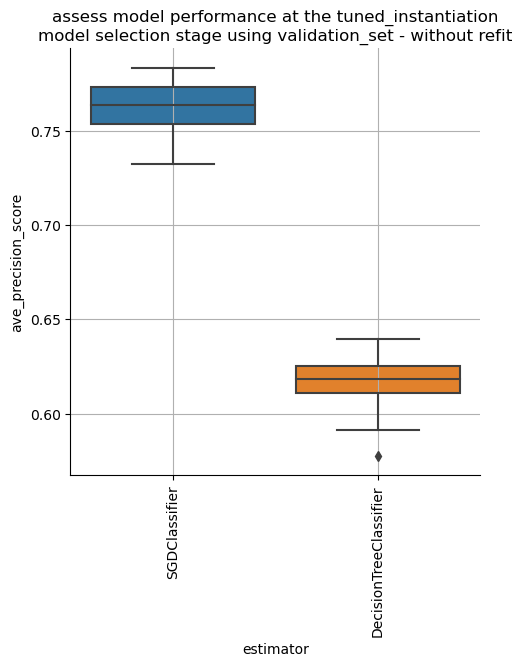

/opt/anaconda3/envs/hw2/lib/python3.10/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


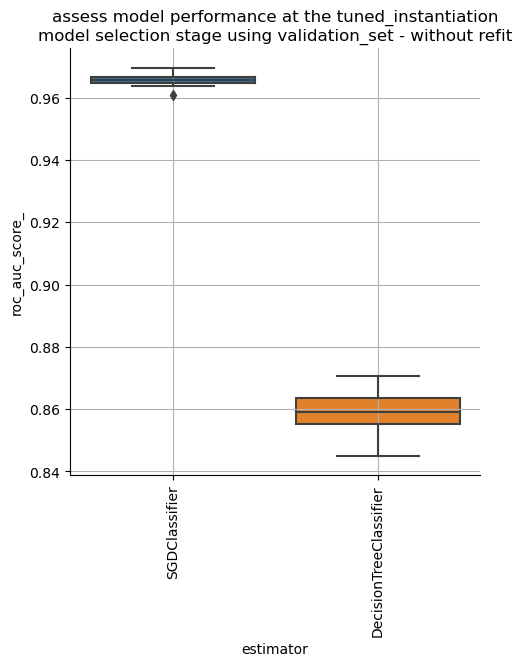

assess model performance at the tuned_instantiation model selection stage using validation_set - without refit
confidence level of the confidence interval: 0.95

                estimator            attr_name  norm_p_val      mean       low      high
0           SGDClassifier  ave_precision_score    0.677771  0.761939  0.755354  0.767961
2  DecisionTreeClassifier  ave_precision_score    0.102968  0.615901  0.608170  0.621431

                estimator       attr_name  norm_p_val      mean       low      high
1           SGDClassifier  roc_auc_score_    0.642725  0.965682  0.964801  0.966559
3  DecisionTreeClassifier  roc_auc_score_    0.814632  0.859414  0.856603  0.861897


In [393]:
# class_eval_dict:
#    key = name of function in classification_utils.py
#    value = [bool, function kwargs]  bool = True then call function
print_plots = False
class_eval_dict={
    'binary': binary,
    'scoring': 'average_precision',
    'get_precision_recall_curves': [True, 
                                    {'print_prc': print_plots, 
                                     'print_prd': print_plots,
                                    }],
    'get_roc_curve': [True, 
                      {
                        'print_roc': print_plots,
                      }]
}

_ = \
    al_utils.execute_and_plot_bootstrap_eval_without_refit(
        estimator_names,
        grid_search_cv_results_df,
        validation_cap_x_df, 
        validation_y_df,
        num_bs_samples=20,
        model_selection_stage='tuned_instantiation',
        data_set_type='validation_set',
        prediction_task_type='classification',
        class_eval_dict=class_eval_dict
)

### visualize the model performance using ranking metrics


************************************************************
************************************************************
************************************************************
************************************************************
SGDClassifier

precision and recall as a function of classification threshold:

validation
tuned


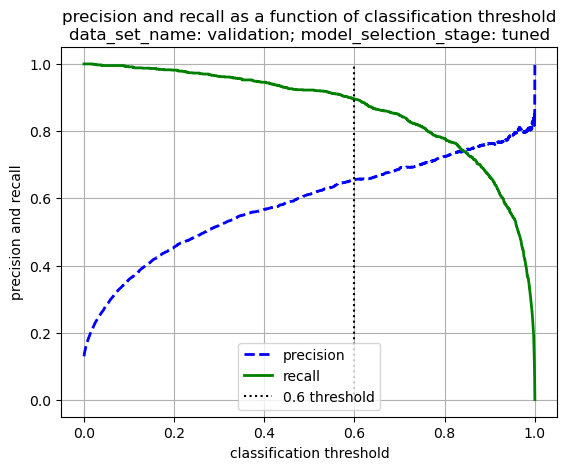


precision-recall curve:



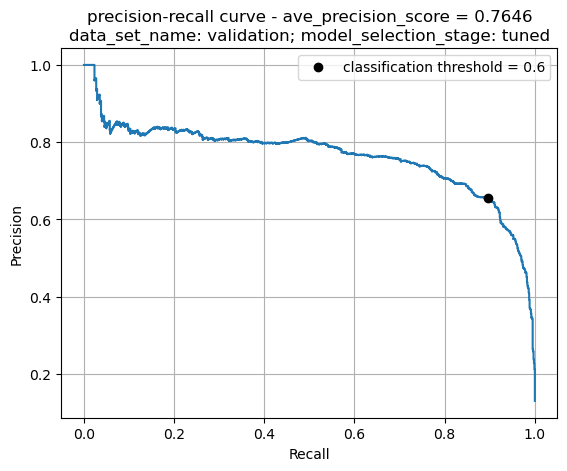

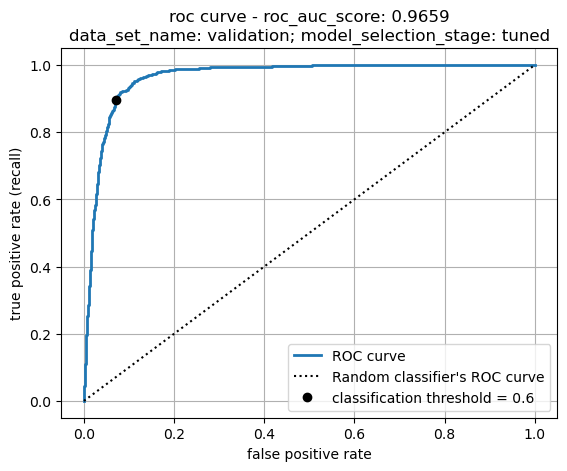

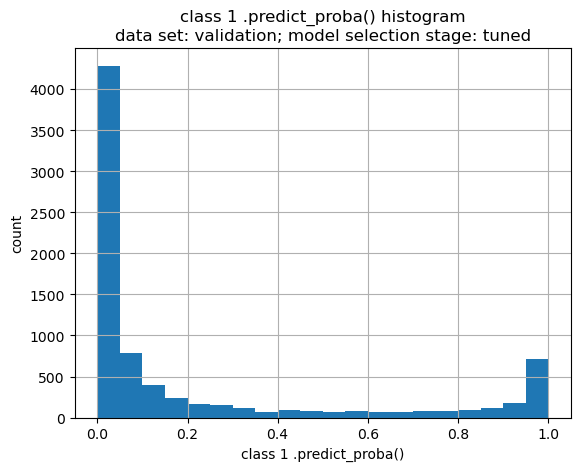

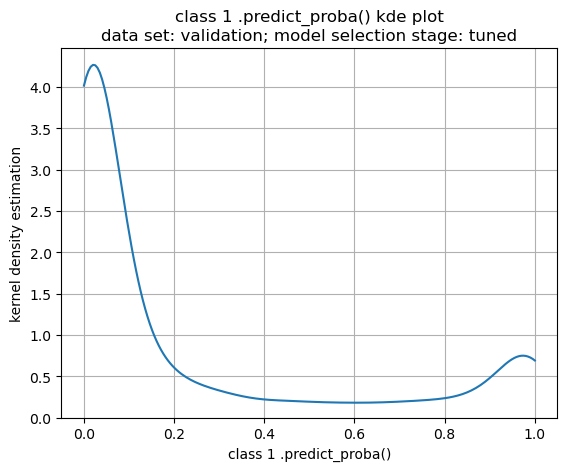

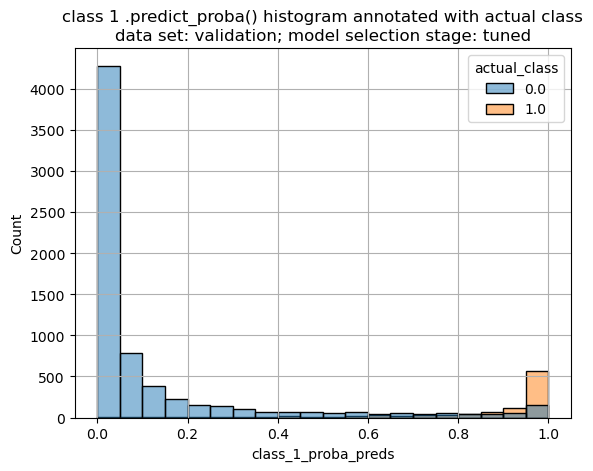

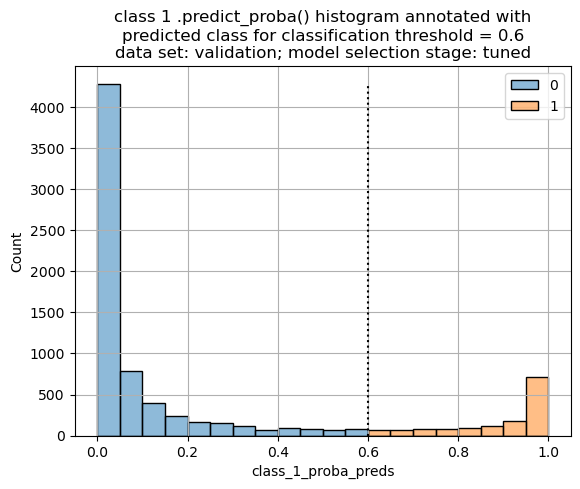

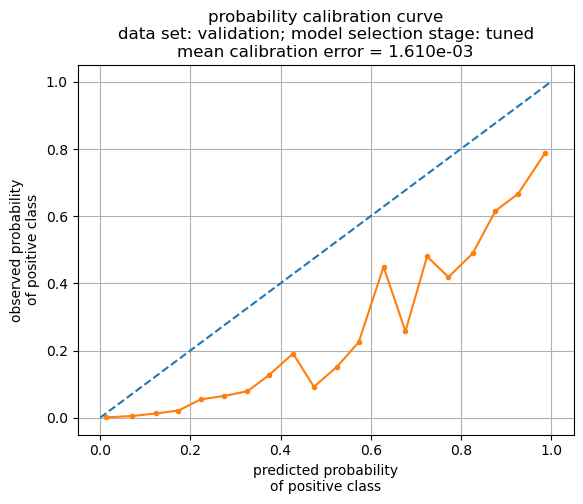


************************************************************
************************************************************
************************************************************
************************************************************
DecisionTreeClassifier

precision and recall as a function of classification threshold:

validation
tuned


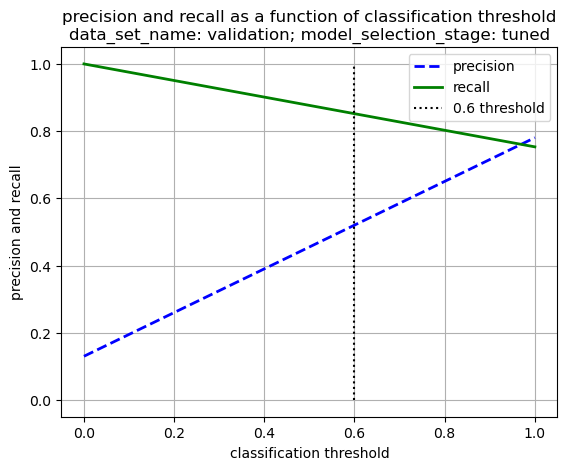


precision-recall curve:



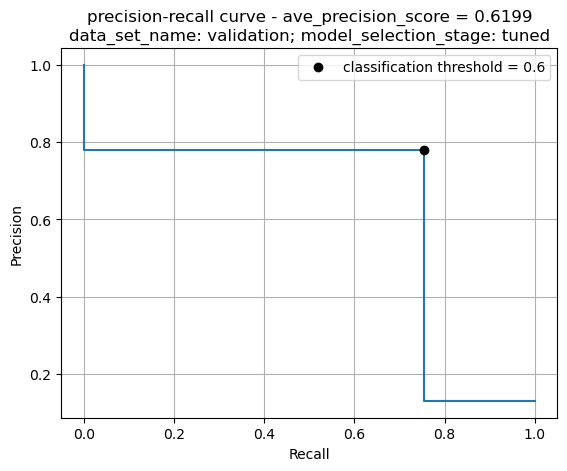

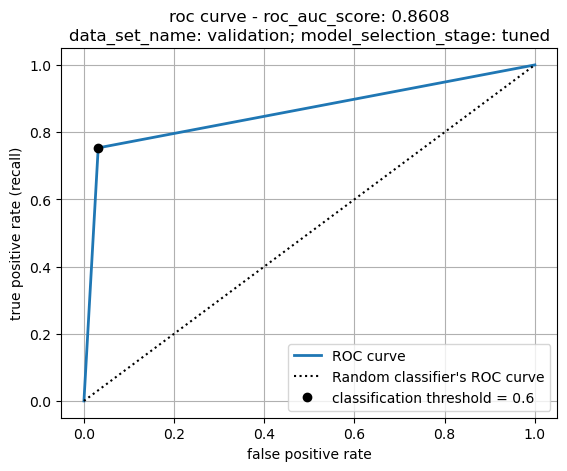

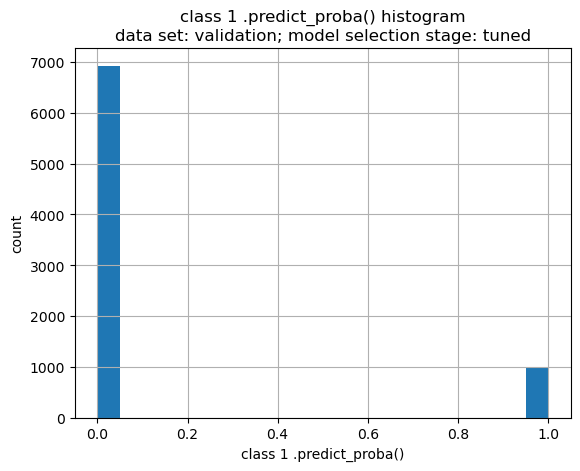

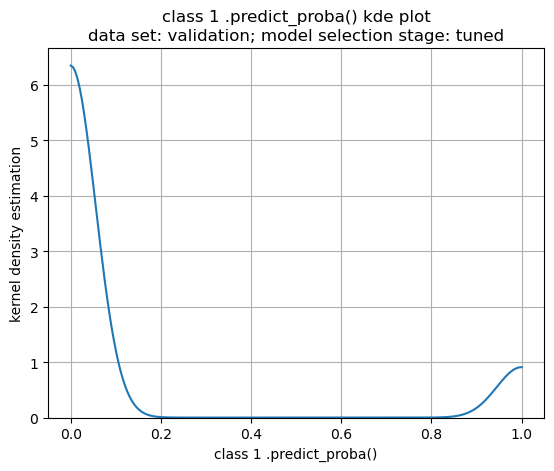

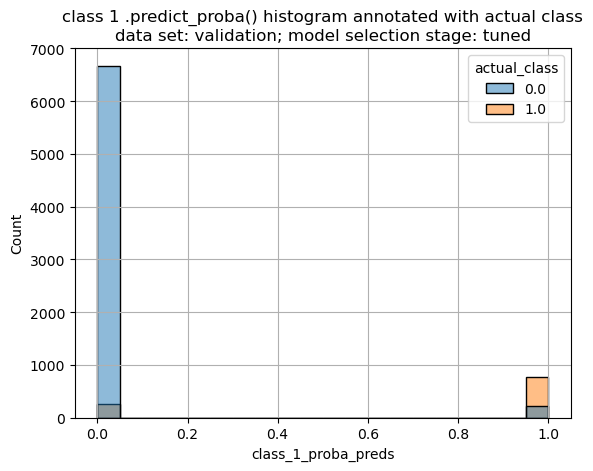

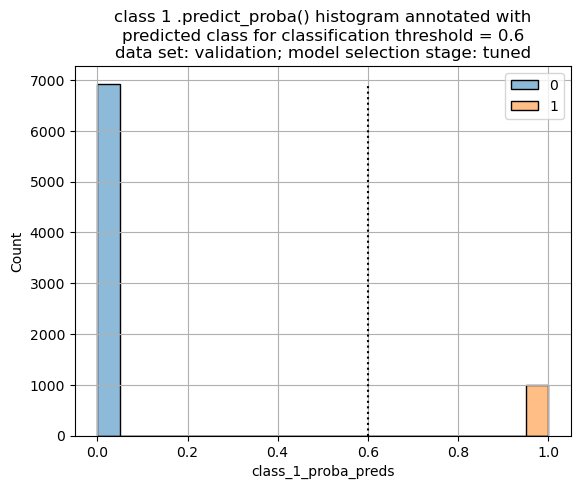

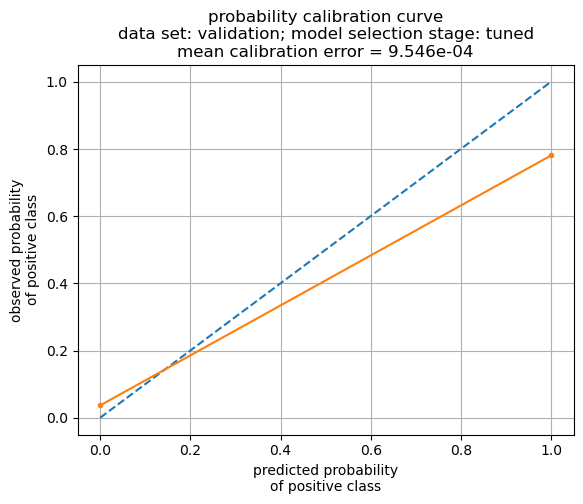

In [394]:
class_perf_dict = \
    class_utils.ranking_metrics_class_perf_assess_binary(
        estimator_names, 
        grid_search_cv_results_df, 
        validation_cap_x_df, 
        validation_y_df, 
        classification_threshold=0.6, 
        cvs_compute=False, 
        cvs_print=False,
        data_set_name='validation', 
        model_selection_stage='tuned'
)

In [395]:
del validation_cap_x_df, validation_y_df

## calibrate the composite estimators

In [396]:
if calibrate_classifiers:
    validation_df = pd.read_csv('validation_df.csv').set_index(keys='index')
    validation_df.index.name = None
    validation_cap_x_df, validation_y_df = validation_df.iloc[:, :-1], validation_df.iloc[:, -1].to_frame()

#### split off some of the validation set for calibration

In [397]:
if calibrate_classifiers:
    cal_split_size = 0.50
    cal_split_random_state = 21

    cal_cap_x_df, cal_y_df, validation_cap_x_df, validation_y_df = al_utils.split_validation_for_calibration(
        pd.concat([validation_cap_x_df, validation_y_df], axis=1),
        cal_split_size=cal_split_size,
        cal_split_random_state=cal_split_random_state
    )

*************************

a_df.shape:
(7921, 17)

target class fractional balance:
y
0.0    0.870092
1.0    0.129908
Name: proportion, dtype: float64

*************************

validation_df.csv:
(3960, 16) (3960, 1)

target class fractional balance:
y
0.0    0.870202
1.0    0.129798
Name: proportion, dtype: float64

*************************

cal_df.csv:
(3961, 16) (3961, 1)

target class fractional balance:
y
0.0    0.869982
1.0    0.130018
Name: proportion, dtype: float64


#### perform the calibration


************************************************************
************************************************************
************************************************************
************************************************************
calibration_data_set: probability calibration
validation_data_set: validation
model_selection_stage: tuned
method: isotonic
ensemble: True



/opt/anaconda3/envs/hw2/lib/python3.10/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


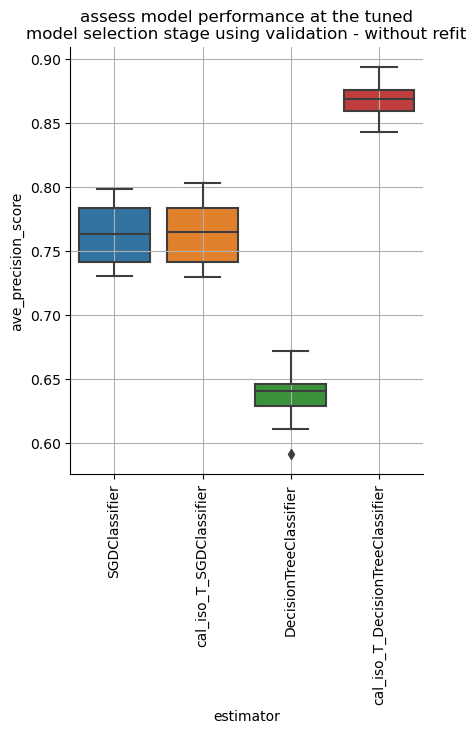

/opt/anaconda3/envs/hw2/lib/python3.10/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


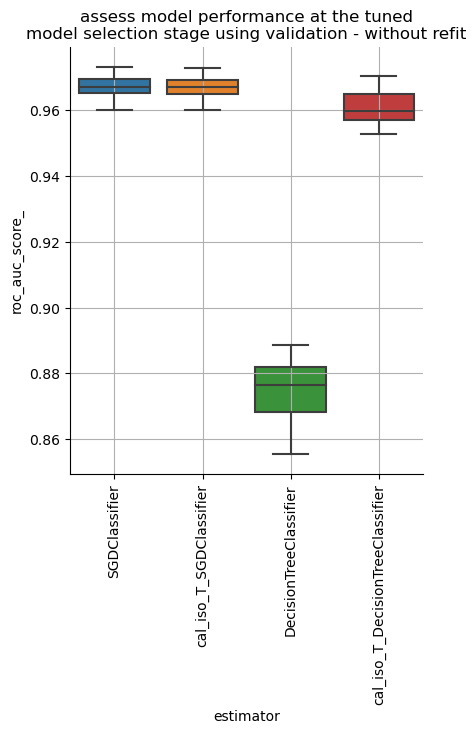

assess model performance at the tuned model selection stage using validation - without refit
confidence level of the confidence interval: 0.95

                          estimator            attr_name  norm_p_val      mean       low      high
0                     SGDClassifier  ave_precision_score    0.057717  0.763871  0.754528  0.773215
2           cal_iso_T_SGDClassifier  ave_precision_score    0.097363  0.763409  0.753846  0.773090
4            DecisionTreeClassifier  ave_precision_score    0.324878  0.637144  0.628361  0.644328
6  cal_iso_T_DecisionTreeClassifier  ave_precision_score    0.898698  0.867072  0.861261  0.872698

                          estimator       attr_name  norm_p_val      mean       low      high
1                     SGDClassifier  roc_auc_score_    0.749644  0.967224  0.965872  0.968493
3           cal_iso_T_SGDClassifier  roc_auc_score_    0.754847  0.967052  0.965683  0.968318
5            DecisionTreeClassifier  roc_auc_score_    0.578935  0.874880  0.8

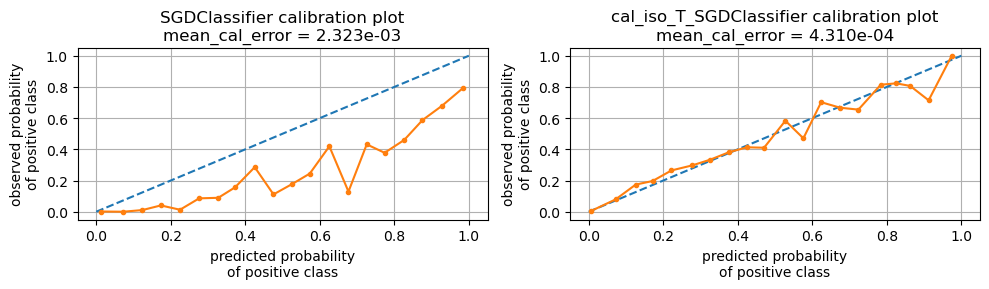


************************************************************
************************************************************
************************************************************
************************************************************
DecisionTreeClassifier  and  cal_iso_T_DecisionTreeClassifier

calibration_data_set: probability calibration
validation_data_set: validation
model_selection_stage: tuned
method: isotonic
ensemble: True



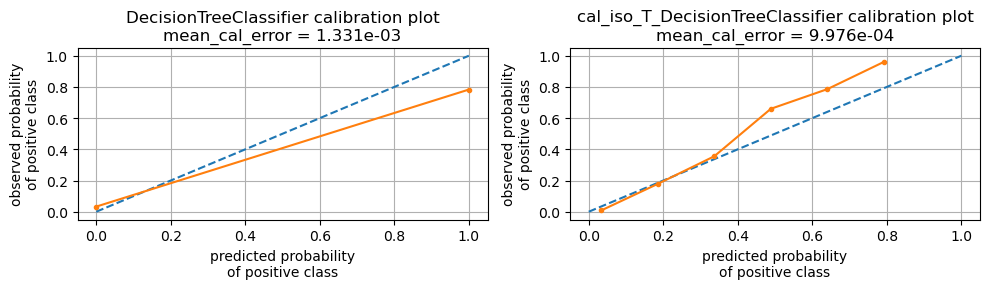

In [398]:
if calibrate_classifiers:
    # class_eval_dict:
    #    key = name of function in classification_utils.py
    #    value = [bool, function kwargs]  bool = True then call function
    print_plots = False
    class_eval_dict={
        'binary': binary,
        'scoring': 'average_precision',
        'get_precision_recall_curves': [True, 
                                        {'print_prc': print_plots, 
                                         'print_prd': print_plots,
                                        }],
        'get_roc_curve': [True, 
                          {
                            'print_roc': print_plots,
                          }]
    }

    sig_cal_grid_search_cv_results_df = al_utils.calibrate_estimators(
        estimator_names, 
        grid_search_cv_results_df, 
        pd.concat([train_cap_x_df, cal_cap_x_df], axis=0),
        pd.concat([train_y_df, cal_y_df], axis=0),
        validation_cap_x_df, 
        validation_y_df,
        class_eval_dict=class_eval_dict,
        calibration_data_set_name='probability calibration', 
        validation_data_set_name='validation',
        model_selection_stage='tuned', 
        method='isotonic',  # 'sigmoid' or 'isotonic'
        ensemble=True
    )

    estimator_names = al_utils.get_estimator_names_helper(grid_search_cv_results_df, 
                                                          sig_cal_grid_search_cv_results_df)
    grid_search_cv_results_df = pd.concat([sig_cal_grid_search_cv_results_df, grid_search_cv_results_df], axis=0)

In [399]:
if calibrate_classifiers:
    del cal_cap_x_df, cal_y_df 

In [400]:
if calibrate_classifiers:
    del validation_cap_x_df, validation_y_df

## check for false discoveries

In [401]:
validation_df = pd.read_csv('validation_df.csv').set_index(keys='index')
validation_df.index.name = None
validation_cap_x_df, validation_y_df = validation_df.iloc[:, :-1], validation_df.iloc[:, -1].to_frame()


************************************************************
************************************************************
************************************************************
************************************************************
SGDClassifier

**************************************************
means of the distributions:
                          ave_precision_score
distribution                                 
bootstrap_sample                     0.752345
randomized_target_sample             0.195030


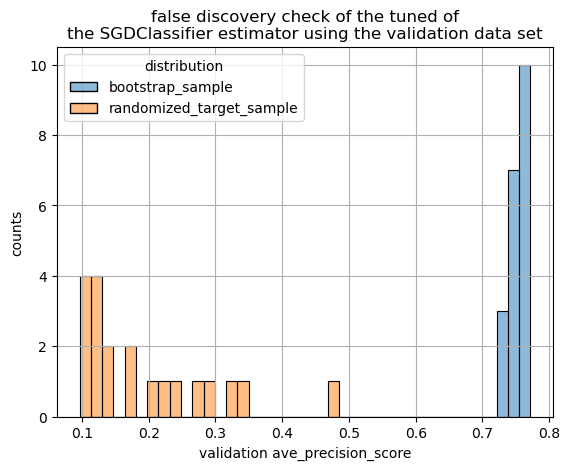


**************************************************
means of the distributions:
                          roc_auc_score_
distribution                            
bootstrap_sample                0.963799
randomized_target_sample        0.495996


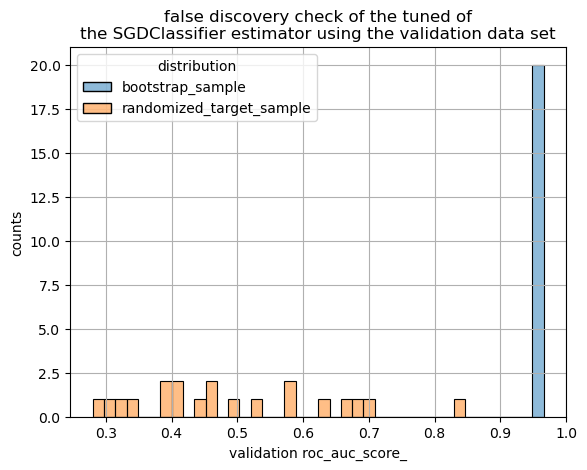


************************************************************
************************************************************
************************************************************
************************************************************
cal_iso_T_SGDClassifier

**************************************************
means of the distributions:
                          ave_precision_score
distribution                                 
bootstrap_sample                     0.753154
randomized_target_sample             0.196043


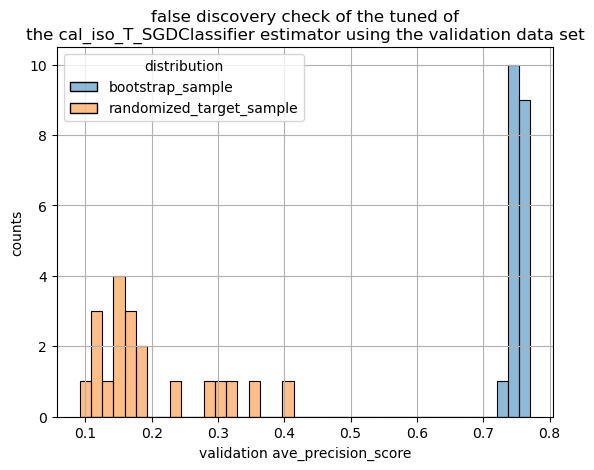


**************************************************
means of the distributions:
                          roc_auc_score_
distribution                            
bootstrap_sample                0.965406
randomized_target_sample        0.497624


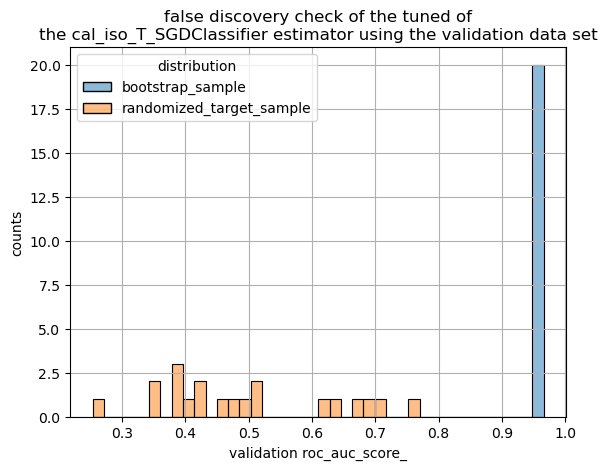


************************************************************
************************************************************
************************************************************
************************************************************
DecisionTreeClassifier

**************************************************
means of the distributions:
                          ave_precision_score
distribution                                 
bootstrap_sample                     0.608816
randomized_target_sample             0.128316


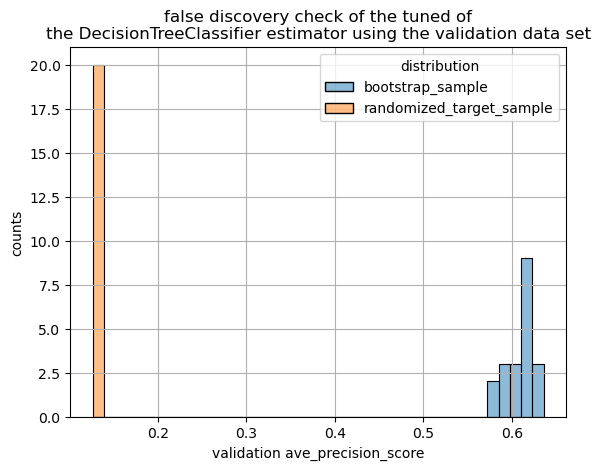


**************************************************
means of the distributions:
                          roc_auc_score_
distribution                            
bootstrap_sample                0.855836
randomized_target_sample        0.491742


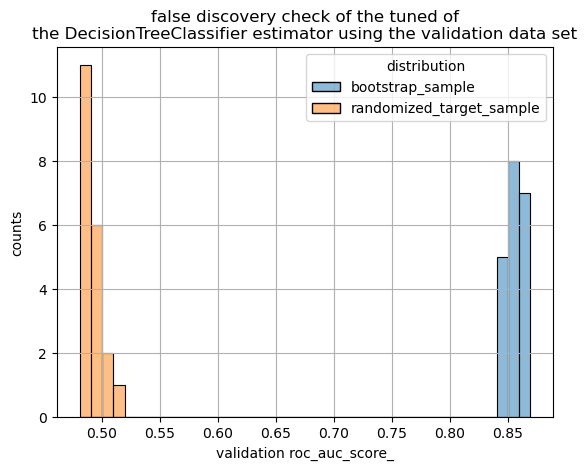


************************************************************
************************************************************
************************************************************
************************************************************
cal_iso_T_DecisionTreeClassifier

**************************************************
means of the distributions:
                          ave_precision_score
distribution                                 
bootstrap_sample                     0.833072
randomized_target_sample             0.128204


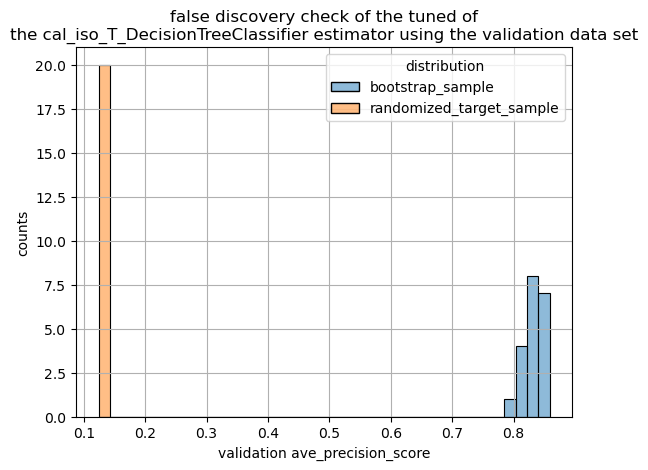


**************************************************
means of the distributions:
                          roc_auc_score_
distribution                            
bootstrap_sample                0.946411
randomized_target_sample        0.488642


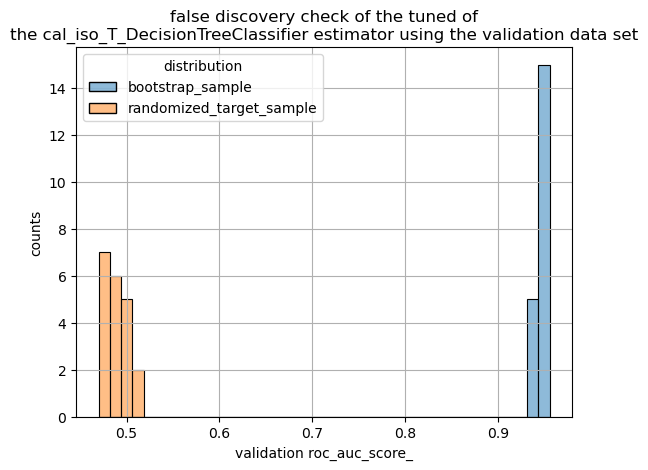

In [402]:
# class_eval_dict:
#    key = name of function in classification_utils.py
#    value = [bool, function kwargs]  bool = True then call function
print_plots = False
class_eval_dict={
    'binary': binary,
    'scoring': 'average_precision',
    'get_precision_recall_curves': [True, 
                                    {'print_prc': print_plots, 
                                     'print_prd': print_plots,
                                    }],
    'get_roc_curve': [True, 
                      {
                        'print_roc': print_plots,
                      }]
}

al_utils.avoiding_false_discoveries_class(
    estimator_names, 
    grid_search_cv_results_df, 
    train_cap_x_df, 
    train_y_df, 
    validation_cap_x_df, 
    validation_y_df, 
    num_samples=20, 
    class_eval_dict=class_eval_dict,
    data_set_name='validation', 
    model_selection_stage='tuned'
)

In [403]:
del validation_cap_x_df, validation_y_df

## time to execute to this point in notebook

In [404]:
end = time.time()
print(f'script run time: {(end - start)/60} minutes')

script run time: 4.791265650590261 minutes


## stop notebook execution and select a model to promote if there is more then one model

In [405]:
if len(estimator_names) > 1:
    sys.exit()

SystemExit: 

/opt/anaconda3/envs/hw2/lib/python3.10/site-packages/IPython/core/interactiveshell.py:3534: UserWarning: To exit: use 'exit', 'quit', or Ctrl-D.
  warn("To exit: use 'exit', 'quit', or Ctrl-D.", stacklevel=1)


## select a model

In [406]:
estimator_names

['SGDClassifier',
 'cal_iso_T_SGDClassifier',
 'DecisionTreeClassifier',
 'cal_iso_T_DecisionTreeClassifier']

In [407]:
best_model = 'cal_iso_T_SGDClassifier'

In [408]:
estimator_names = [best_model]

## permutation feature importance

In [409]:
perm_imp_dict, _ = \
    al_utils.permutation_importance_helper(
        estimator_names, 
        grid_search_cv_results_df, 
        train_cap_x_df, 
        train_y_df, 
        scoring = ['average_precision', 'roc_auc'],
        stop_reporting_threshold=0
)

'CalibratedClassifierCV' object has no attribute 'steps'
using alternative method to extract attributes from trained estimator

**************************************************

estimator:  cal_iso_T_SGDClassifier

metric: average_precision
    attr_10  0.279 +/- 0.008
    attr_11  0.196 +/- 0.005
    attr_7   0.120 +/- 0.002
    attr_4   0.078 +/- 0.003
    attr_13  0.059 +/- 0.003
    attr_3   0.002 +/- 0.000
    attr_12  0.002 +/- 0.001
    attr_14  0.001 +/- 0.000
    attr_9   0.001 +/- 0.000
    attr_8   0.001 +/- 0.000
    attr_2   0.001 +/- 0.000

metric: roc_auc
    attr_10  0.097 +/- 0.001
    attr_11  0.088 +/- 0.002
    attr_4   0.044 +/- 0.001
    attr_7   0.022 +/- 0.001
    attr_13  0.022 +/- 0.000
    attr_15  0.002 +/- 0.000
    attr_12  0.001 +/- 0.000
    attr_1   0.001 +/- 0.000
    attr_6   0.000 +/- 0.000
    attr_3   0.000 +/- 0.000
    attr_2   0.000 +/- 0.000
    attr_9   0.000 +/- 0.000
    attr_8   0.000 +/- 0.000
    attr_14  0.000 +/- 0.000


## tune classification threshold for classification with classification metrics

### select the threshold

### check out the classifier as a function of classification threshold - select the classfication threshold at which the classifier will operated to make predictions

In [410]:
validation_df = pd.read_csv('validation_df.csv').set_index(keys='index')
validation_df.index.name = None
validation_cap_x_df, validation_y_df = validation_df.iloc[:, :-1], validation_df.iloc[:, -1].to_frame()

In [411]:
class_threshold_list = np.arange(0, 1.1, 0.1)
thresh_class_perf_dict = \
    class_utils.class_thresh_metrics_class_perf_assess_binary(
        best_model, 
        estimator_names, 
        grid_search_cv_results_df, 
        validation_cap_x_df, 
        validation_y_df, 
        class_threshold_list, 
        cvs_compute=False, 
        cvs_print=False, 
        data_set_name='validation', 
        model_selection_stage='tuned'
    )

cal_iso_T_SGDClassifier

************************************************************
************************************************************

classification report:
data_set_name: validation; model_selection_stage: tuned
(note - classification threshold = 0.0)

              precision    recall  f1-score   support

         0.0     1.0000    0.3192    0.4839      3446
         1.0     0.1797    1.0000    0.3047       514

    accuracy                         0.4076      3960
   macro avg     0.5899    0.6596    0.3943      3960
weighted avg     0.8935    0.4076    0.4607      3960


confusion matrix:
data_set_name: validation; model_selection_stage: tuned
(note - classification threshold = 0.0)

[[1100 2346]
 [   0  514]]

************************************************************
************************************************************

classification report:
data_set_name: validation; model_selection_stage: tuned
(note - classification threshold = 0.1)

              prec

/opt/anaconda3/envs/hw2/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/anaconda3/envs/hw2/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/anaconda3/envs/hw2/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/anaconda3/envs/hw2/l


confusion matrix:
data_set_name: validation; model_selection_stage: tuned
(note - classification threshold = 1.0)

[[3446    0]
 [ 514    0]]


cal_iso_T_SGDClassifier


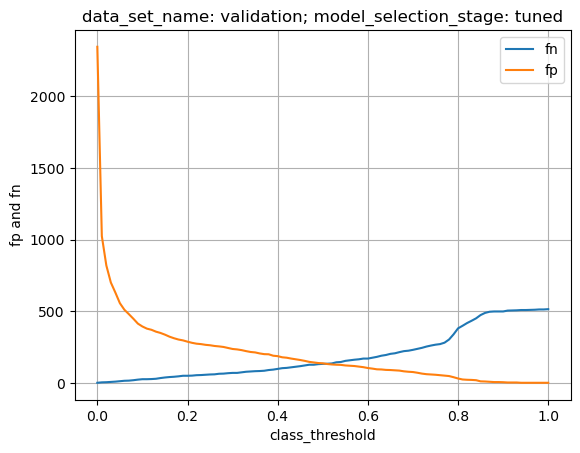

In [412]:
class_threshold_list = np.arange(0, 1.01, 0.01)
class_utils.plot_errors_as_a_function_of_classification_threshold(
    best_model, 
    estimator_names, 
    grid_search_cv_results_df,
    validation_cap_x_df, 
    validation_y_df, 
    class_threshold_list, 
    data_set_name='validation',
    model_selection_stage='tuned'
)

### set the classification threshold

In [413]:
classification_threshold = 0.11

### use bootstrapping to understand how the precision will vary at this classification threshold


************************************************************
************************************************************
cal_iso_T_SGDClassifier


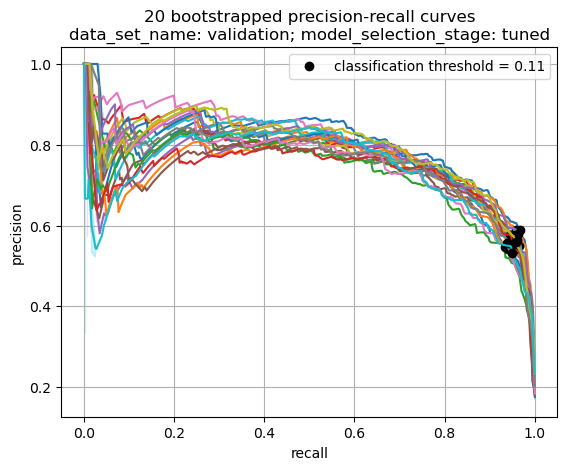


******************************
ave_precision_score

95.0% confidence interval for ave_precision_score bootstrap sample:
   sample conf int low: 0.7538460791033698
   sample mean: 0.7634085238982262
   sample conf int high: 0.7730901328574394
   sample conf int margin of error: 0.00962202687703484

H0: ave_precision_score sample was sampled from a normal distribution
H1: ave_precision_score sample was not sampled from a normal distribution
p_value: 0.09736298664015576

******************************
precision

95.0% confidence interval for precision bootstrap sample:
   sample conf int low: 0.5549549342368273
   sample mean: 0.5616035265533565
   sample conf int high: 0.5685703245567484
   sample conf int margin of error: 0.006807695159960547

H0: precision sample was sampled from a normal distribution
H1: precision sample was not sampled from a normal distribution
p_value: 0.5795572260036225

******************************
recall

95.0% confidence interval for recall bootstrap sample:

/opt/anaconda3/envs/hw2/lib/python3.10/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


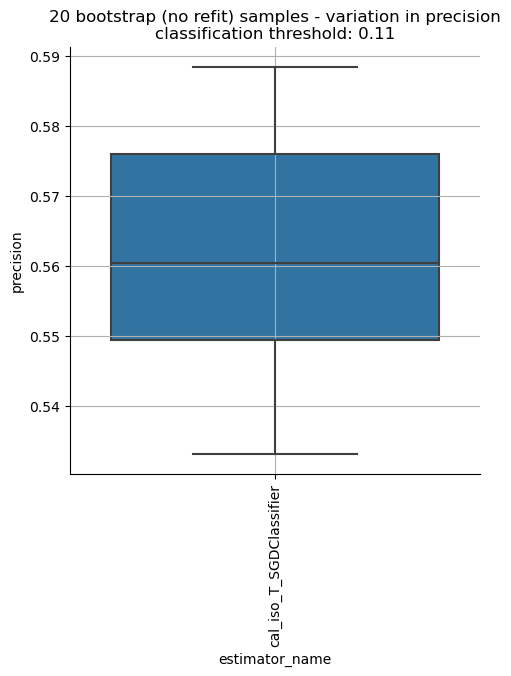

/opt/anaconda3/envs/hw2/lib/python3.10/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


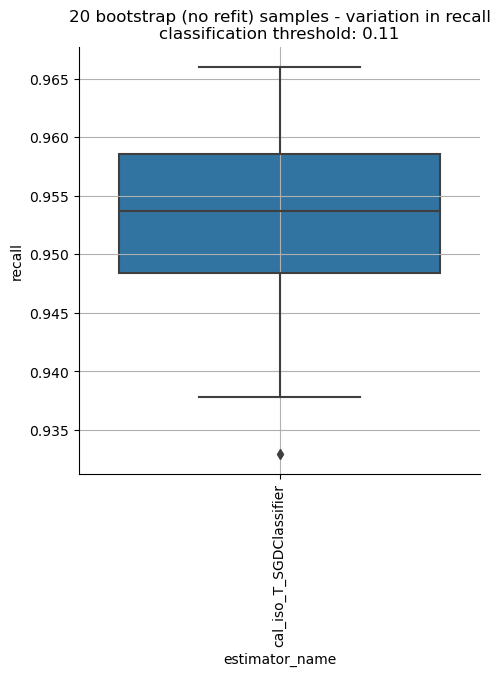

In [414]:
class_utils.precision_recall_bootstrap_no_refit_binary(
    estimator_names, 
    grid_search_cv_results_df,
    validation_cap_x_df,
    validation_y_df, 
    n_bootstrap=20,
    data_set_name='validation', 
    model_selection_stage='tuned',
    classification_threshold=classification_threshold
)


************************************************************
************************************************************
cal_iso_T_SGDClassifier


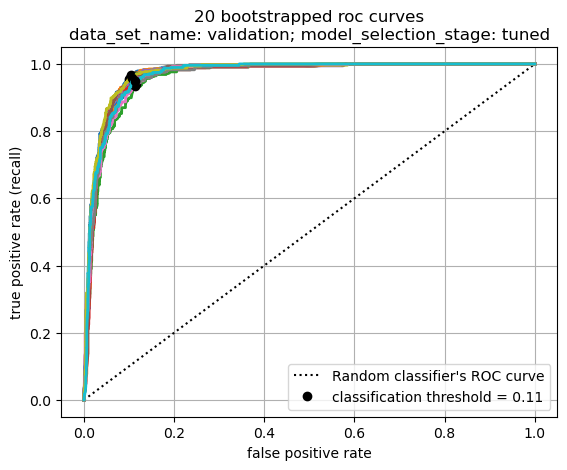


******************************
roc_auc_score_

95.0% confidence interval for roc_auc_score_ bootstrap sample:
   sample conf int low: 0.9656827228174685
   sample mean: 0.9670520330795517
   sample conf int high: 0.9683184276746084
   sample conf int margin of error: 0.0013178524285699655

H0: roc_auc_score_ sample was sampled from a normal distribution
H1: roc_auc_score_ sample was not sampled from a normal distribution
p_value: 0.7548465303451188

******************************
trp

95.0% confidence interval for trp bootstrap sample:
   sample conf int low: 0.9481342165278029
   sample mean: 0.9523990230069581
   sample conf int high: 0.9558879620478171
   sample conf int margin of error: 0.0038768727600070885

H0: trp sample was sampled from a normal distribution
H1: trp sample was not sampled from a normal distribution
p_value: 0.56615584662233

******************************
fpr

95.0% confidence interval for fpr bootstrap sample:
   sample conf int low: 0.10712290807563549
   sa

/opt/anaconda3/envs/hw2/lib/python3.10/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


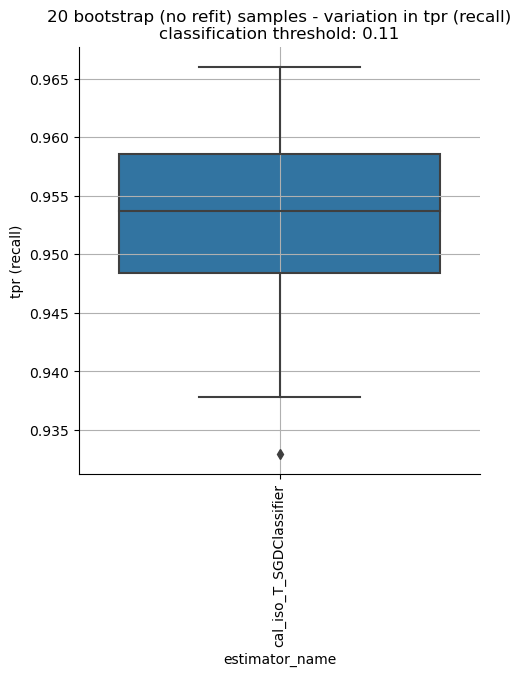

/opt/anaconda3/envs/hw2/lib/python3.10/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


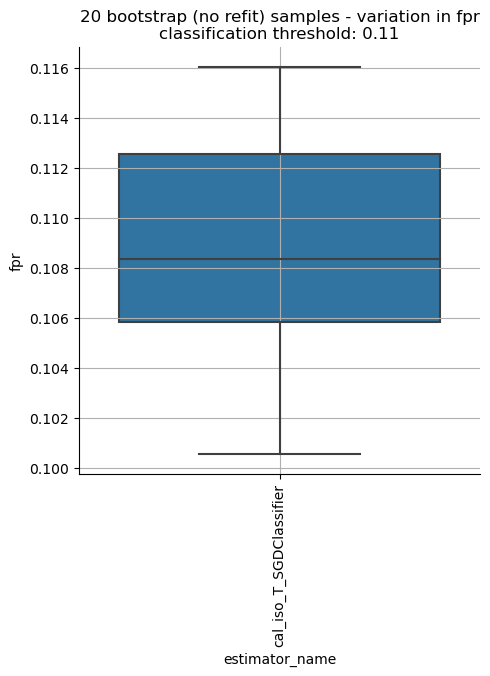

In [415]:
class_utils.roc_curve_bootstrap_no_refit_binary(
    estimator_names, 
    grid_search_cv_results_df, 
    validation_cap_x_df, 
    validation_y_df, 
    n_bootstrap=20,
    data_set_name='validation', 
    model_selection_stage='tuned',
    classification_threshold=classification_threshold
)

### can we do better? higher resolution scan of classification threshold around selected classification threshold

In [416]:
start = classification_threshold - 0.05
stop = classification_threshold + 0.06
step_size = 0.01

class_threshold_list = np.arange(start, stop, step_size)
thresh_class_perf_dict = \
    class_utils.class_thresh_metrics_class_perf_assess_binary(
        best_model, 
        estimator_names, 
        grid_search_cv_results_df, 
        validation_cap_x_df, 
        validation_y_df, 
        class_threshold_list, 
        cvs_compute=False, 
        cvs_print=False, 
        data_set_name='validation', 
        model_selection_stage='tuned'
    )

cal_iso_T_SGDClassifier

************************************************************
************************************************************

classification report:
data_set_name: validation; model_selection_stage: tuned
(note - classification threshold = 0.06)

              precision    recall  f1-score   support

         0.0     0.9953    0.8520    0.9181      3446
         1.0     0.4950    0.9728    0.6562       514

    accuracy                         0.8677      3960
   macro avg     0.7452    0.9124    0.7871      3960
weighted avg     0.9303    0.8677    0.8841      3960


confusion matrix:
data_set_name: validation; model_selection_stage: tuned
(note - classification threshold = 0.06)

[[2936  510]
 [  14  500]]

************************************************************
************************************************************

classification report:
data_set_name: validation; model_selection_stage: tuned
(note - classification threshold = 0.07)

              p

### examine some classifier evaluations to better understand how the classiifcation metrics vary with classification threshold

In [417]:
best_estimator = \
    grid_search_cv_results_df.loc[grid_search_cv_results_df.estimator == best_model, 'best_estimator'].iloc[0]


classification report:
data_set_name: validation; model_selection_stage: tuned
(note - classification threshold = 0.11)

              precision    recall  f1-score   support

         0.0     0.9919    0.8903    0.9384      3446
         1.0     0.5640    0.9514    0.7082       514

    accuracy                         0.8982      3960
   macro avg     0.7780    0.9208    0.8233      3960
weighted avg     0.9364    0.8982    0.9085      3960


confusion matrix:
data_set_name: validation; model_selection_stage: tuned
(note - classification threshold = 0.11)

[[3068  378]
 [  25  489]]

precision and recall as a function of classification threshold:

validation
tuned


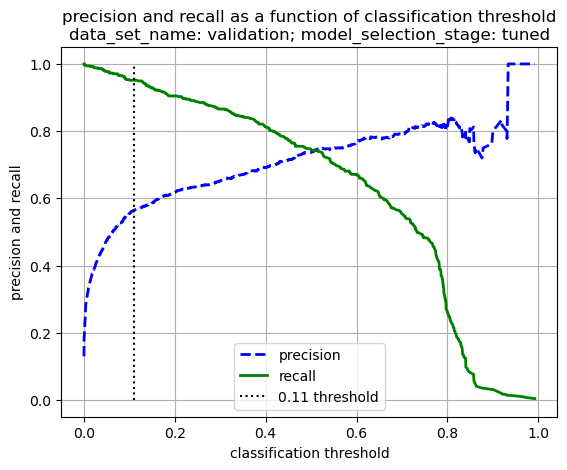


precision-recall curve:



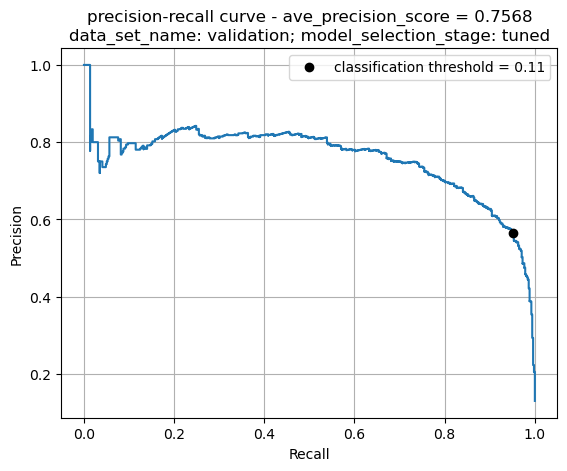

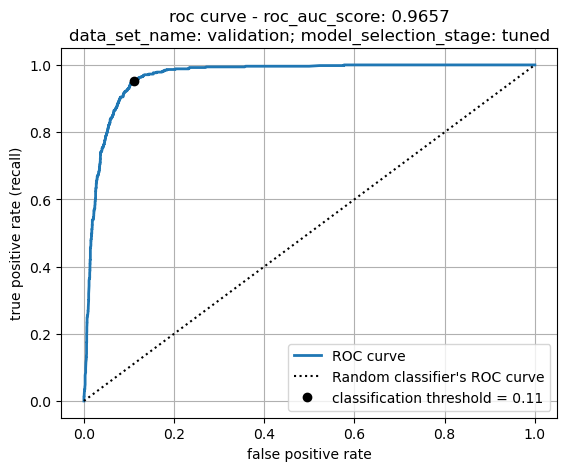

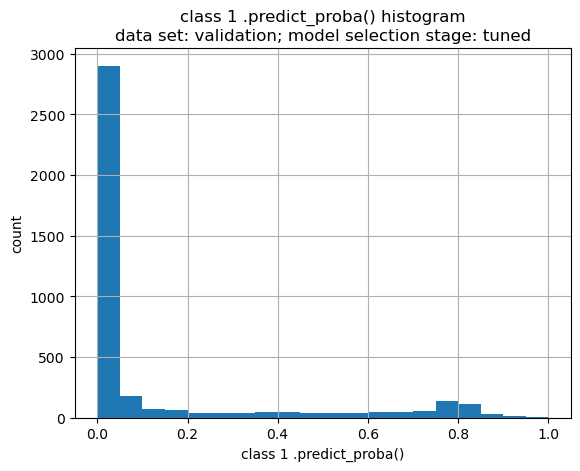

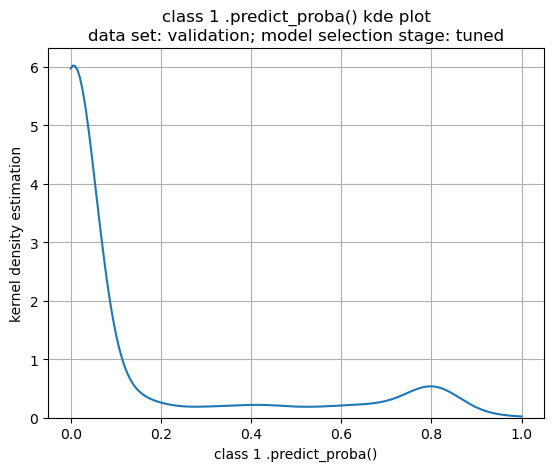

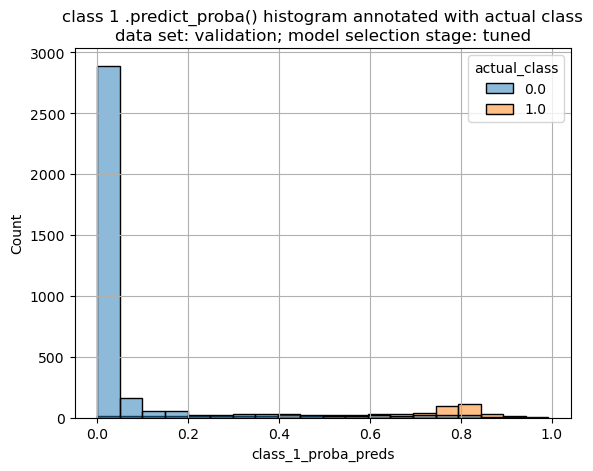

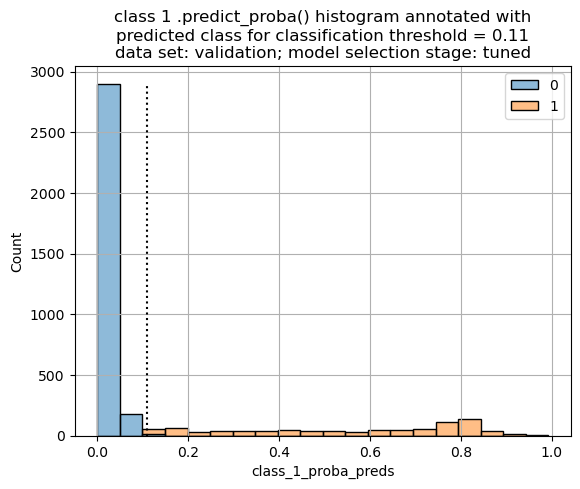

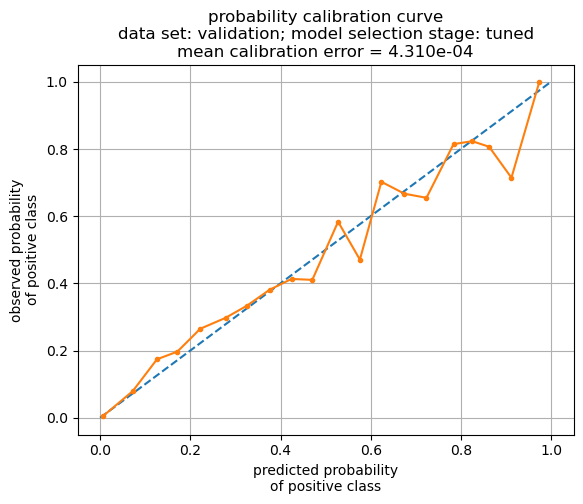

In [418]:
class_perf_dict = class_utils.classification_performance(
    best_estimator, 
    validation_cap_x_df, 
    validation_y_df.values.ravel(), 
    classification_threshold=classification_threshold,
    binary=True,
    # https://scikit-learn.org/stable/modules/model_evaluation.html
    cvs_scoring_dict={
        'accuracy': 'accuracy',
        'precision': 'precision',
        'recall': 'recall',
        'f1': 'f1'
    },
    cr_digits=4,
    cr_print=True,  # print classification report
    cm_print=True,  # print confusion matrix
    cvs_compute=False,  # compute cross_val_scores (classification threshold = 0.5 always)
    cvs_print=True,  # print cross_val_scores (classification threshold = 0.5 always) - ignored if cvs_compute=False
    prc_print=True,  # print precision and recall curves as a function of classification threshold
    prd_print=True,  # print precision recall curves
    roc_print=True,  # print roc curve
    data_set_name='validation', 
    model_selection_stage='tuned'
)

In [419]:
del validation_cap_x_df, validation_y_df

## serialize model and classification threshold

In [420]:
now = datetime.datetime.now()
date_time_prefix = str(now).replace('-', '_').replace(' ', '_').replace(':', '_').replace('.', '_')[:-4]

date_time_prefix

'2023_11_29_22_17_34_52'

In [421]:
best_estimator_file_name = date_time_prefix + '_cancer_screening_model' + '.pkl'

best_estimator_file_name

'2023_11_29_22_17_34_52_cancer_screening_model.pkl'

In [422]:
best_estimator = \
    grid_search_cv_results_df.loc[grid_search_cv_results_df.estimator == best_model, 'best_estimator'].iloc[0]

model_dict = {
    'classification_threshold': classification_threshold,
    'best_model': best_model,
    'composite_estimator': best_estimator
}

In [423]:
with open(best_estimator_file_name, 'wb') as f:
    pickle.dump(model_dict, f)

## evaluate model on the test set

In [424]:


# Load the model from disk
with open('2023_11_29_18_57_02_69_cancer_screening_model.pkl', 'rb') as file:
    model_dict = pickle.load(file)

In [425]:
# Check the type of the item associated with the 'composite_estimator' key
print(type(model_dict['composite_estimator']))

# If the 'composite_estimator' is indeed a model object, you should be able to call predict on it
if hasattr(model_dict['composite_estimator'], 'predict'):
    model = model_dict['composite_estimator']
    predictions = model.predict(train_cap_x_df)
    # ... proceed with the evaluation as before
else:
    print("The 'composite_estimator' item is not a model object.")


<class 'sklearn.calibration.CalibratedClassifierCV'>


In [426]:
# Step 1: Load the Data
data = pd.read_csv('test_df.csv')

# Assuming you have a split of features and target in your dataset
X_test =  data.drop(['y'], axis=1)
y_test = data['y']  # Replace 'y' with the actual target column name if necessary


# Step 2: Load the Models
with open('2023_11_29_18_57_02_69_cancer_screening_model.pkl', 'rb') as file:
    best_model = pickle.load(file)['composite_estimator']




************************************************************
************************************************************
cal_iso_T_SGDClassifier


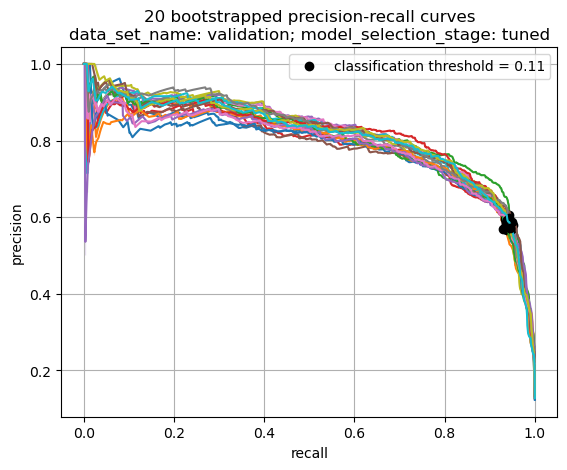


******************************
ave_precision_score

95.0% confidence interval for ave_precision_score bootstrap sample:
   sample conf int low: 0.7934019541885162
   sample mean: 0.7999236920981018
   sample conf int high: 0.8061095409407345
   sample conf int margin of error: 0.00635379337610914

H0: ave_precision_score sample was sampled from a normal distribution
H1: ave_precision_score sample was not sampled from a normal distribution
p_value: 0.10492955908502413

******************************
precision

95.0% confidence interval for precision bootstrap sample:
   sample conf int low: 0.5764781264458136
   sample mean: 0.580836656916089
   sample conf int high: 0.5862664213196404
   sample conf int margin of error: 0.004894147436913354

H0: precision sample was sampled from a normal distribution
H1: precision sample was not sampled from a normal distribution
p_value: 0.4341874529917463

******************************
recall

95.0% confidence interval for recall bootstrap sample:


/opt/anaconda3/envs/hw2/lib/python3.10/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


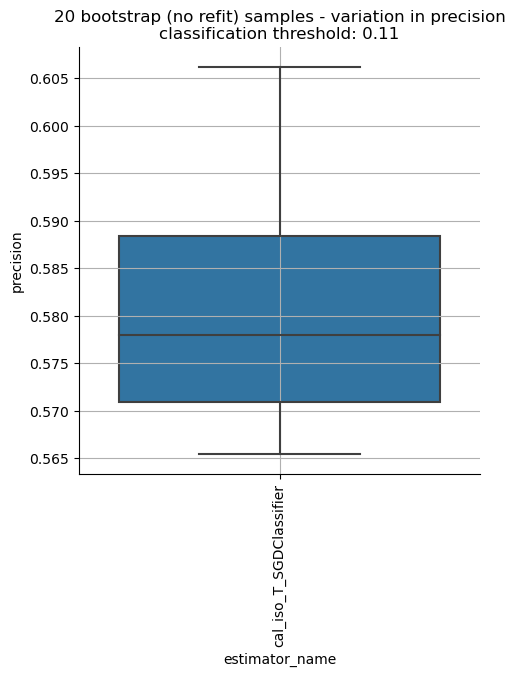

/opt/anaconda3/envs/hw2/lib/python3.10/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


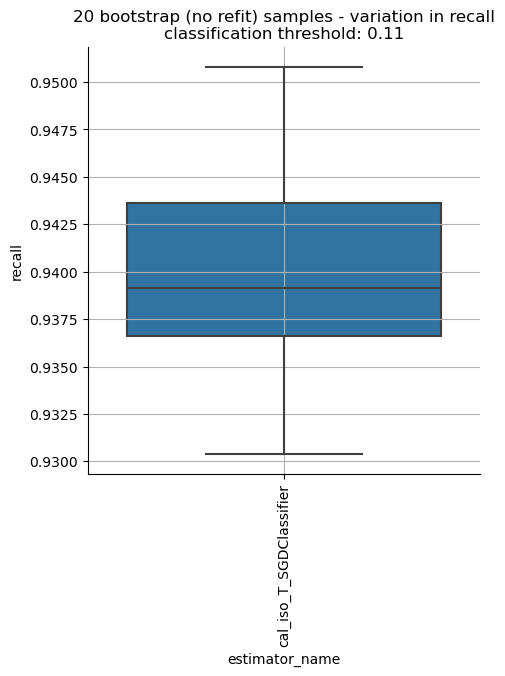

In [427]:
from sklearn.metrics import precision_score, recall_score
classification_threshold = .11
class_utils.precision_recall_bootstrap_no_refit_binary(
    estimator_names, 
    grid_search_cv_results_df,
    X_test,
    y_test, 
    n_bootstrap=20,
    data_set_name='validation', 
    model_selection_stage='tuned',
    classification_threshold=classification_threshold
)

